### SDS-043-CardioSentinel Exploratory Data Analysis

This notebook performs a standard EDA per the README: imports, data load, summary statistics, missing values, distributions, correlation / multicollinearity checks, a scaling demo, and a quick look at class balance.

Findings:
- very clean dataset
- no missing values
- no duplicate rows or single-value columns
- no skew
- no statistical outliers
- no correlation, but several features show high multicollinearity
- 9 binary features, plus the target
- blood pressure can be split into systolic and diastolic
- Representation:
    - 64% do not have heart attack risk, 36% do
    - 70% Male
    - 90% Smokers
    - 65% Diabetic
    - 60% drink Alcohol 
    - Asia and Europe are double or more other continents
    - Northern hemisphere is nearly double Southern hemisphere
    - Remaining features are evenly represented
- Categorical features have even rates between no risk and at risk
- There does not appear to be a single contributor standing out, but a subtle combination may be determined by deep learning

In [41]:
# Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
sns.set_theme(style='whitegrid')


In [26]:
# Load dataset, try both likely locations
possible_paths = [
    Path('..') / 'data' / 'raw' / 'heart_attack_prediction_dataset.csv',  # when running from notebooks/
    Path('data') / 'raw' / 'heart_attack_prediction_dataset.csv'          # when running from project root
]

data_path = next((p for p in possible_paths if p.exists()), None)

if data_path is None:
    raise FileNotFoundError("Could not find heart_attack_prediction_dataset.csv in expected locations.")

print("Using data file:", data_path)
df = pd.read_csv(data_path)

# Quick look
print('Shape:', df.shape)
display(df.head())

Using data file: ..\data\raw\heart_attack_prediction_dataset.csv
Shape: (8763, 26)


,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168189,Average,0,0,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.813242,Unhealthy,1,0,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.078353,Healthy,1,1,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.828130,Average,1,0,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804299,Unhealthy,1,0,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [27]:
# Basic summary and missing values
print('Column dtypes and non-null counts:')
display(df.info())

# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean() * 100).sort_values(ascending=False)
missing_table = pd.concat([missing, missing_pct], axis=1, keys=['missing_count','missing_pct']).loc[lambda x: x['missing_count']>0]
print('Missing values (columns with any missing):')
display(missing_table)

Column dtypes and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null 

None

Missing values (columns with any missing):


,missing_count,missing_pct


In [ ]:
# Duplicated rows?
df.duplicated().sum()

np.int64(0)

In [ ]:
# Columns with single value?
const_cols = [c for c in df.columns if df[c].nunique(dropna=False) == 1]
print("Constant columns:", const_cols)

Constant columns: []


In [29]:
# Split blood pressure into systolic and diastolic
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df = df.drop(columns=['Blood Pressure', 'Patient ID'])  # drop original and ID column

In [30]:
print('Descriptive statistics (numeric):')
display(df.describe().T)

Descriptive statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
Age,8763.0,53.707977,21.249509,18.000000,35.000000,54.000000,72.000000,90.000000
Cholesterol,8763.0,259.877211,80.863276,120.000000,192.000000,259.000000,330.000000,400.000000
Heart Rate,8763.0,75.021682,20.550948,40.000000,57.000000,75.000000,93.000000,110.000000
Diabetes,8763.0,0.652288,0.476271,0.000000,0.000000,1.000000,1.000000,1.000000
Family History,8763.0,0.492982,0.499979,0.000000,0.000000,0.000000,1.000000,1.000000
Smoking,8763.0,0.896839,0.304186,0.000000,1.000000,1.000000,1.000000,1.000000
Obesity,8763.0,0.501426,0.500026,0.000000,0.000000,1.000000,1.000000,1.000000
Alcohol Consumption,8763.0,0.598083,0.490313,0.000000,0.000000,1.000000,1.000000,1.000000
Exercise Hours Per Week,8763.0,10.014284,5.783745,0.002442,4.981579,10.069559,15.050018,19.998709
Previous Heart Problems,8763.0,0.495835,0.500011,0.000000,0.000000,0.000000,1.000000,1.000000


In [31]:
# Identify numeric and categorical features (simple heuristic)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
# treat low-cardinality numeric columns as categorical for EDA (e.g., 0/1 flags)
for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].nunique() <= 10 and col not in cat_cols:
        cat_cols.append(col)
        if col in numeric_cols:
            numeric_cols.remove(col)

print(f'Numeric cols ({len(numeric_cols)}):', numeric_cols)
print(f'Categorical / low-cardinality cols ({len(cat_cols)}):', cat_cols)

Numeric cols (10): ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Systolic', 'Diastolic']
Categorical / low-cardinality cols (16): ['Sex', 'Diet', 'Country', 'Continent', 'Hemisphere', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk']


In [ ]:
# Low variance numeric features
num_df = df[numeric_cols].select_dtypes(include=['float64', 'int64']).fillna(0)
selector = VarianceThreshold(threshold=0.01)  # 0.01 = drop features with <1% variance
selector.fit(num_df)

low_var_cols = num_df.columns[~selector.get_support()]
print("Low-variance numerical columns:", low_var_cols)

Low-variance numerical columns: Index([], dtype='object')


In [44]:
# Low variance categorical features
cat_low_var = []
for c in cat_cols:
    top_freq = df[c].value_counts(normalize=True, dropna=False).iloc[0]
    if top_freq > 0.95:   # 95% of samples share the same category
        cat_low_var.append((c, round(top_freq*100, 1)))
pd.DataFrame(cat_low_var, columns=['Feature', '% Most Frequent'])

,Feature,% Most Frequent


## Distributions and visual checks

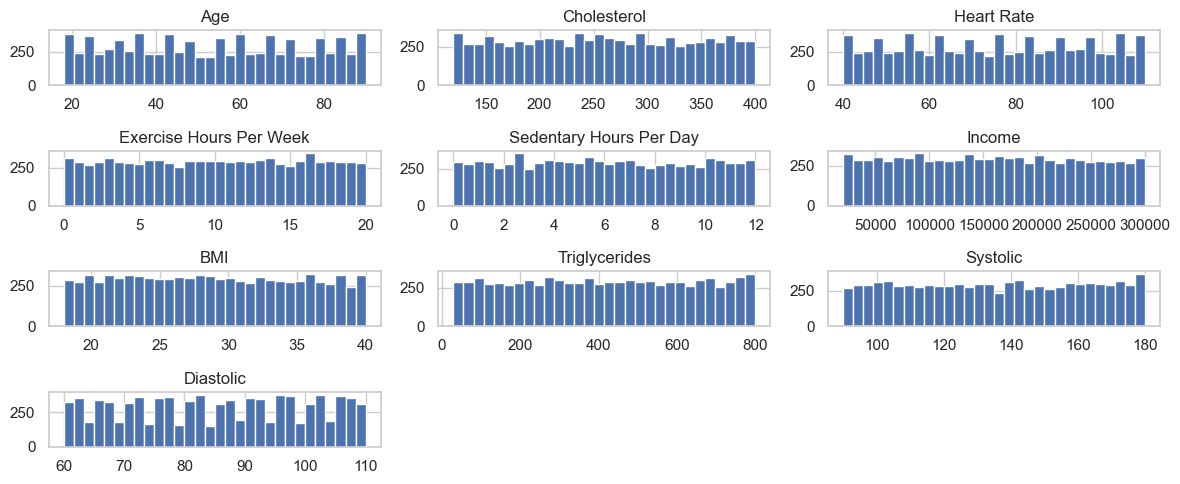

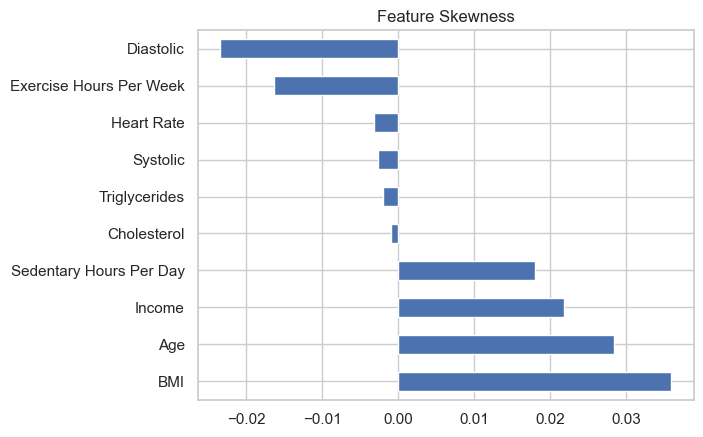

In [33]:
# Histograms for numeric features (compact)
if numeric_cols:
    _ = df[numeric_cols].hist(
        figsize=(12, max(4, len(numeric_cols) // 2)),
        bins=30
    )
    plt.tight_layout()
    plt.show()

# Check skew and potential transformation
skew_vals = df[numeric_cols].skew().sort_values(ascending=False)
skew_vals.plot(kind='barh', title='Feature Skewness')
plt.show()

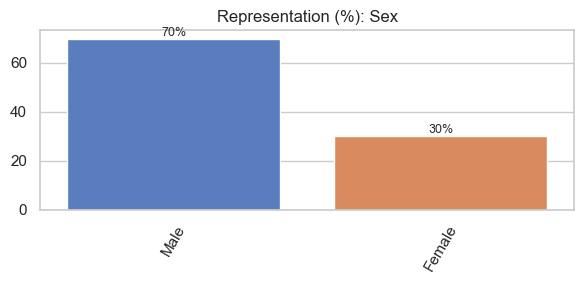

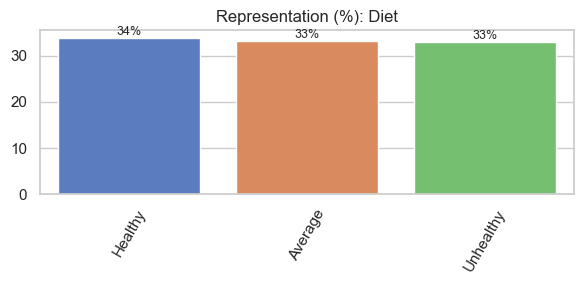

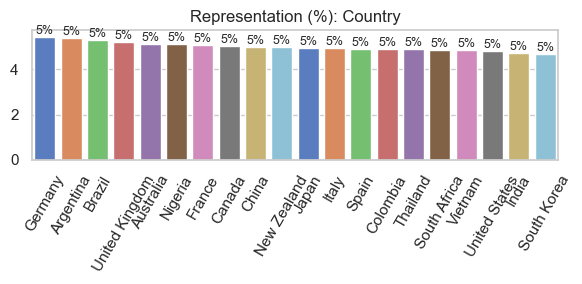

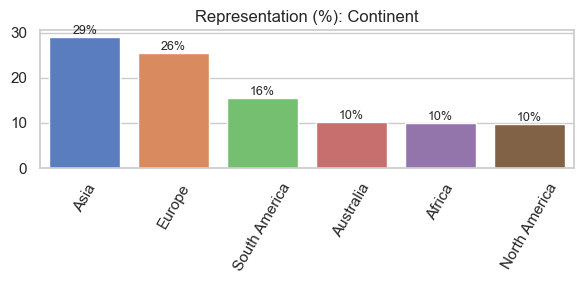

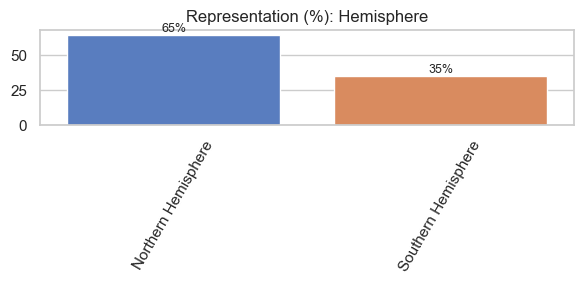

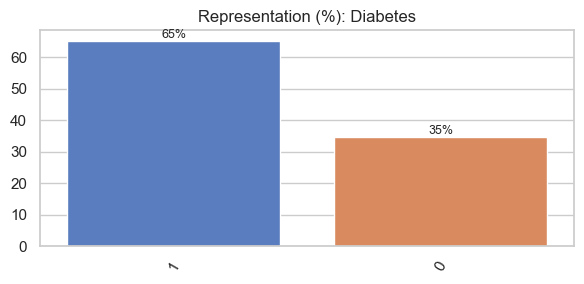

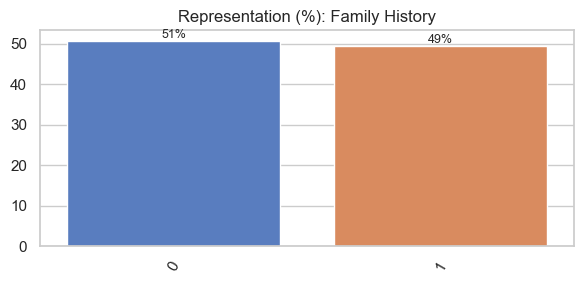

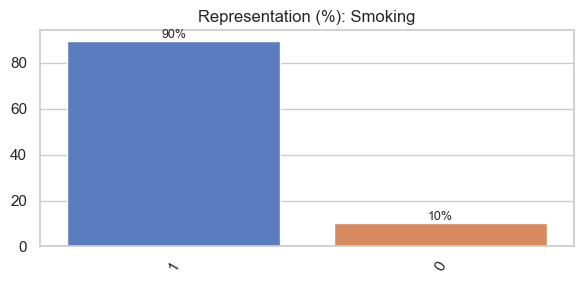

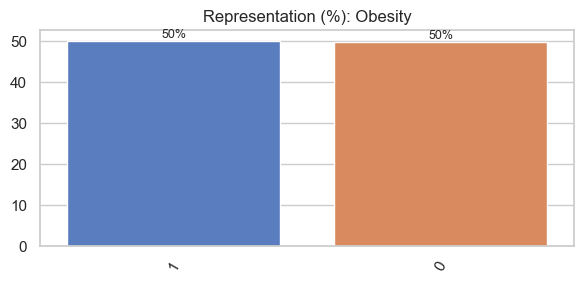

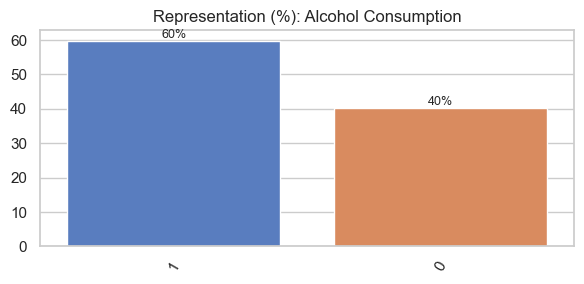

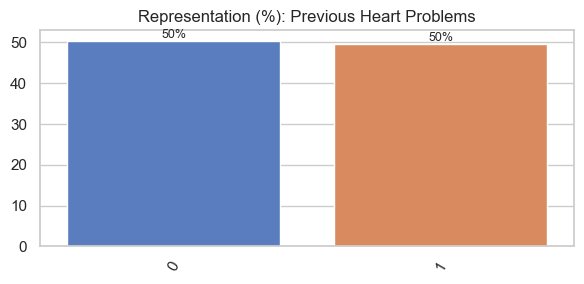

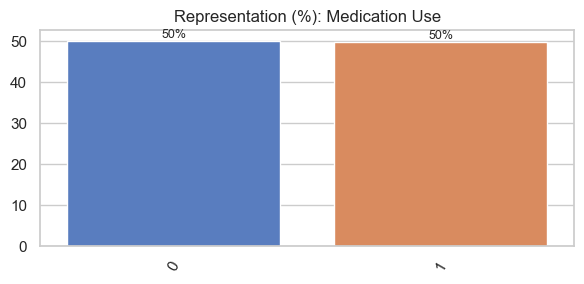

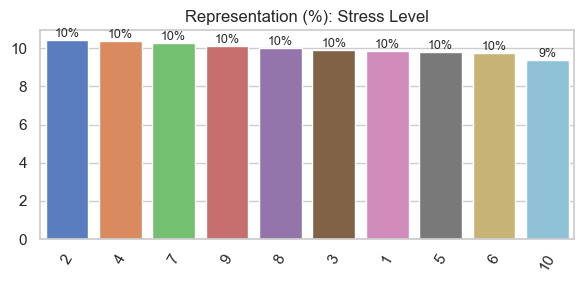

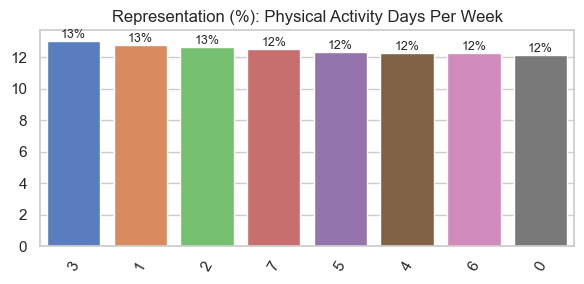

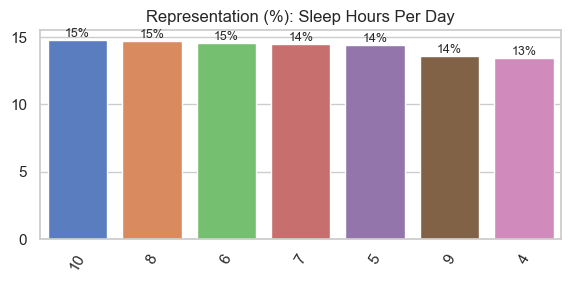

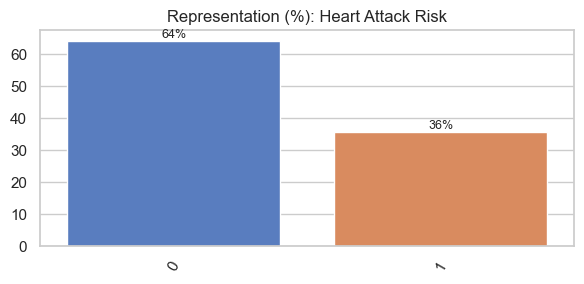

In [34]:
# Value counts for categorical / low-cardinality features (percentages only)
for col in cat_cols:
    plt.figure(figsize=(6, 3))

    # Calculate value counts as percentages
    vc = df[col].value_counts(dropna=False, normalize=True) * 100

    # Create bar plot
    sns.barplot(
        x=vc.index.astype(str),
        y=vc.values,
        palette="muted",
        hue=vc.index.astype(str),
        legend=False
    )

    # Add percentage labels above each bar
    for i, pct in enumerate(vc.values):
        plt.text(
            i, pct, f"{pct:.0f}%",
            ha="center", va="bottom", fontsize=9
        )

    # Formatting
    plt.title(f"Representation (%): {col}")
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

In [ ]:
# Correlation with target
target_corr = df[numeric_cols + ['Heart Attack Risk']].corr()['Heart Attack Risk'].sort_values(key=abs, ascending=False)
display(target_corr)

Heart Attack Risk          1.000000
Cholesterol                0.019340
Systolic                   0.018585
Exercise Hours Per Week    0.011133
Triglycerides              0.010471
Income                     0.009628
Diastolic                 -0.007509
Age                        0.006403
Sedentary Hours Per Day   -0.005613
Heart Rate                -0.004251
BMI                        0.000020
Name: Heart Attack Risk, dtype: float64

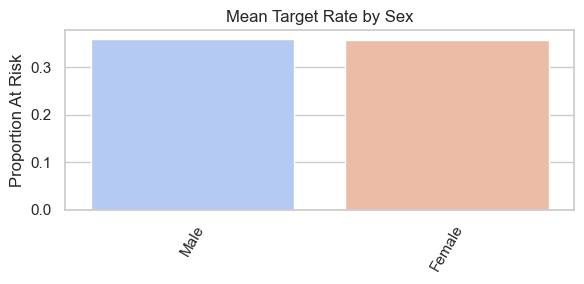

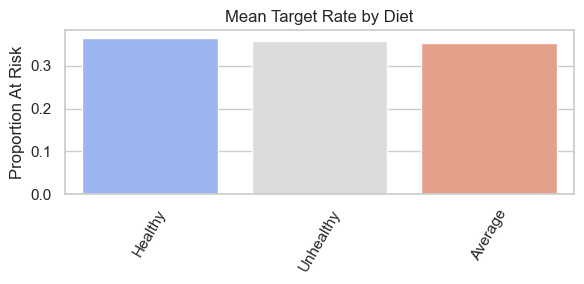

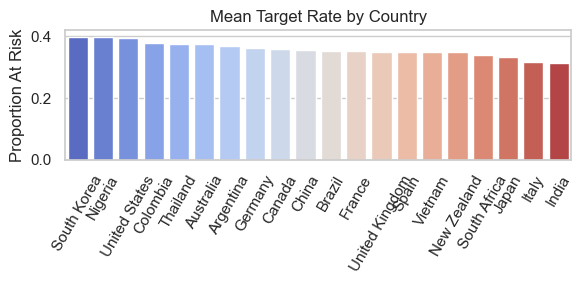

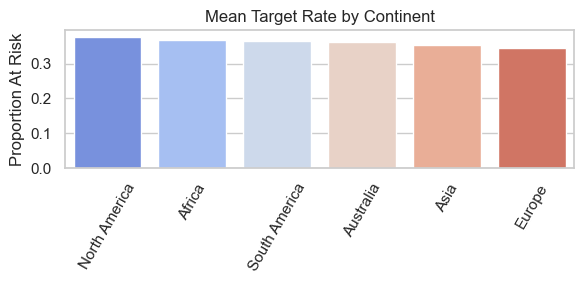

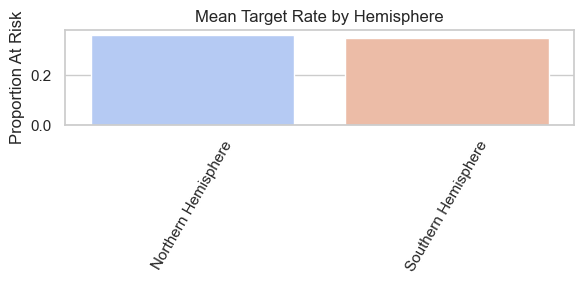

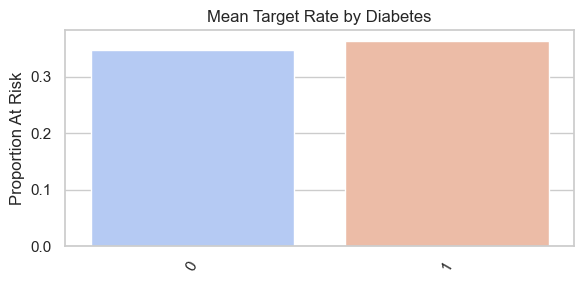

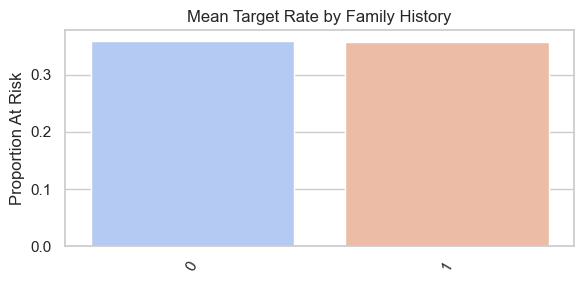

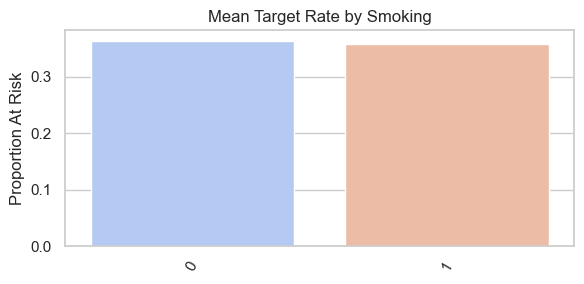

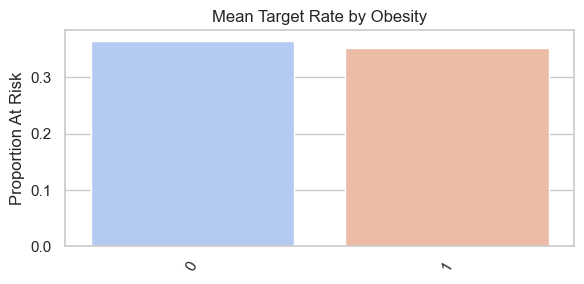

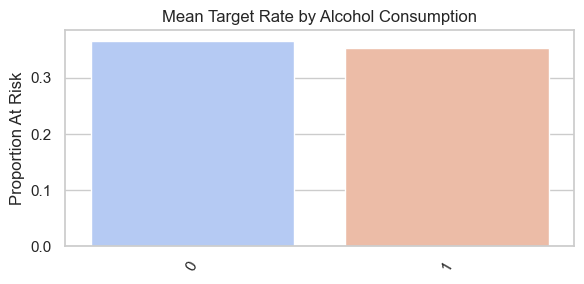

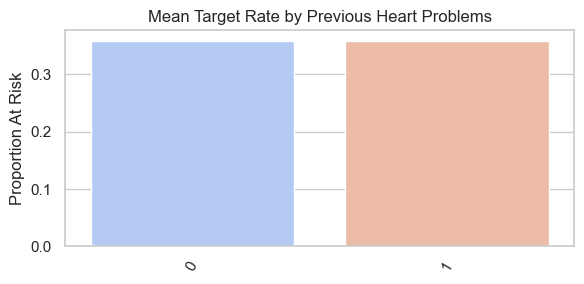

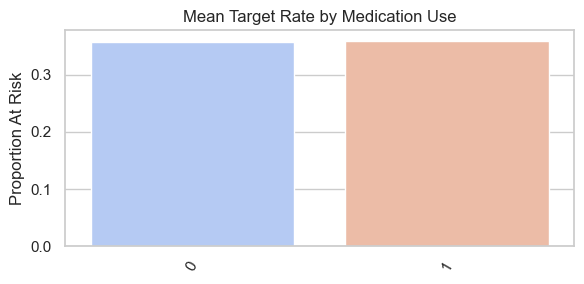

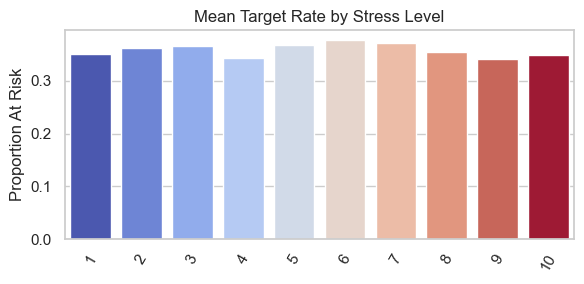

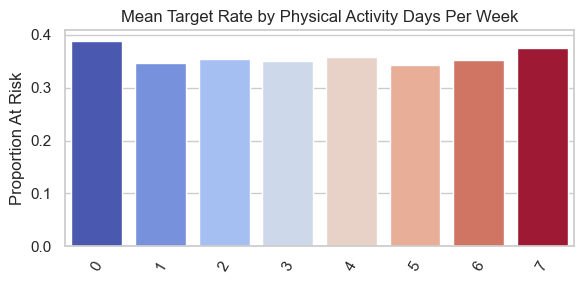

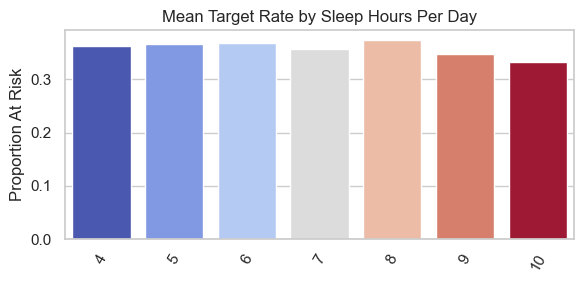

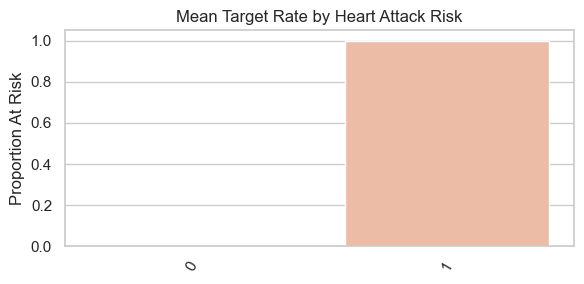

In [50]:
# Categorical feature relationship with target
for col in cat_cols:
    plt.figure(figsize=(6,3))
    cat_target = df.groupby(col)['Heart Attack Risk'].mean().sort_values(ascending=False)
    sns.barplot(x=cat_target.index, y=cat_target.values, palette="coolwarm", hue=cat_target.index, legend=False)
    plt.title(f"Mean Target Rate by {col}")
    plt.ylabel("Proportion At Risk")
    plt.xlabel(None)
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

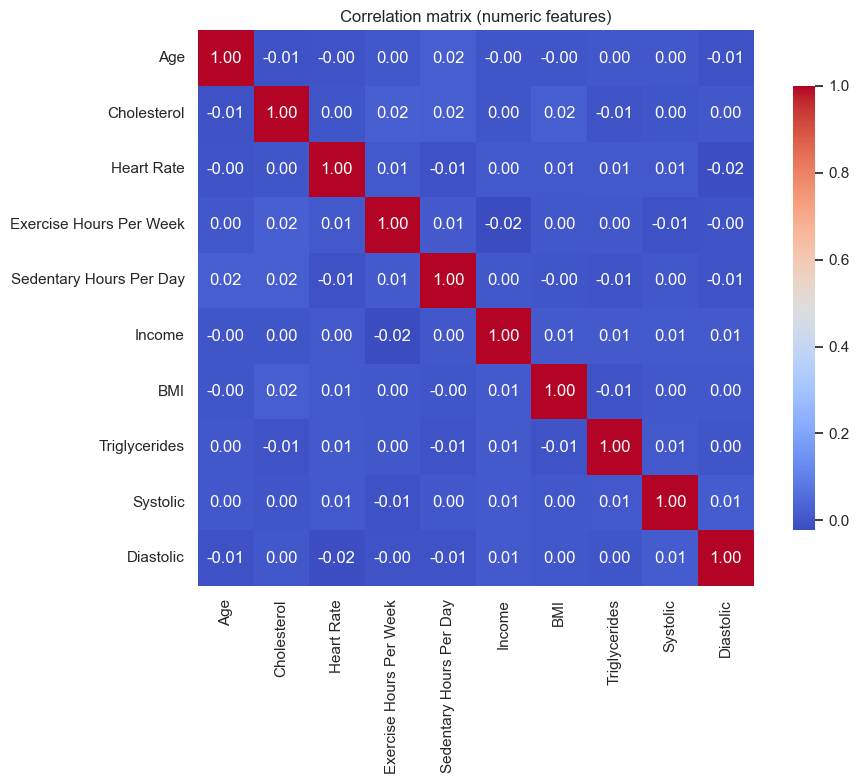

In [35]:
# Correlation heatmap for numeric features
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
    plt.title('Correlation matrix (numeric features)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns to show a correlation matrix.')

In [ ]:
# Count statistical outliers in numeric columns using IQR (1.5*IQR) and Z-score (|z|>3)
outlier_stats = []

for c in numeric_cols:
    col_vals = df[c].dropna().astype(float)
    n = len(col_vals)
    if n == 0:
        continue

    # IQR method
    q1 = col_vals.quantile(0.25)
    q3 = col_vals.quantile(0.75)
    iqr = q3 - q1
    lower_iqr = q1 - 1.5 * iqr
    upper_iqr = q3 + 1.5 * iqr
    mask_iqr = (col_vals < lower_iqr) | (col_vals > upper_iqr)
    count_iqr = int(mask_iqr.sum())
    pct_iqr = 100.0 * count_iqr / n

    # Z-score method
    mean = col_vals.mean()
    std = col_vals.std(ddof=0)
    if std > 0:
        z_scores = (col_vals - mean) / std
        mask_z3 = z_scores.abs() > 3
        count_z3 = int(mask_z3.sum())
        pct_z3 = 100.0 * count_z3 / n
    else:
        count_z3 = 0
        pct_z3 = 0.0

    outlier_stats.append({
        'column': c,
        'n': n,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'lower_iqr': lower_iqr,
        'upper_iqr': upper_iqr,
        'count_iqr': count_iqr,
        'pct_iqr': pct_iqr,
        'count_z3': count_z3,
        'pct_z3': pct_z3
    })

outliers_df = pd.DataFrame(outlier_stats).set_index('column')
outliers_df = outliers_df.sort_values(by='pct_iqr', ascending=False)

print('Outlier summary (IQR 1.5x and |z|>3):')
display(outliers_df)

# Quick human-readable summary
total_outlier_cols = (outliers_df['count_iqr'] > 0).sum()
print(f'{total_outlier_cols} numeric columns contain at least one IQR-based outlier.')

# Show columns with the highest proportion of IQR outliers
top = outliers_df[outliers_df['count_iqr'] > 0].head(5)
if not top.empty:
    print('\nTop columns by IQR outlier percentage:')
    for col, row in top.iterrows():
        print(f" - {col}: {row['count_iqr']} outliers ({row['pct_iqr']:.2f}%)")
else:
    print('No IQR-based outliers detected in numeric columns.')

Outlier summary (IQR 1.5x and |z|>3):


,n,q1,q3,iqr,lower_iqr,upper_iqr,count_iqr,pct_iqr,count_z3,pct_z3
column,,,,,,,,,,
Age,8763,35.000000,72.000000,37.000000,-20.500000,127.500000,0,0.0,0,0.0
Cholesterol,8763,192.000000,330.000000,138.000000,-15.000000,537.000000,0,0.0,0,0.0
Heart Rate,8763,57.000000,93.000000,36.000000,3.000000,147.000000,0,0.0,0,0.0
Exercise Hours Per Week,8763,4.981579,15.050018,10.068439,-10.121080,30.152677,0,0.0,0,0.0
Sedentary Hours Per Day,8763,2.998794,9.019124,6.020331,-6.031702,18.049621,0,0.0,0,0.0
Income,8763,88310.000000,227749.000000,139439.000000,-120848.500000,436907.500000,0,0.0,0,0.0
BMI,8763,23.422985,34.324594,10.901609,7.070572,50.677007,0,0.0,0,0.0
Triglycerides,8763,225.500000,612.000000,386.500000,-354.250000,1191.750000,0,0.0,0,0.0
Systolic,8763,112.000000,158.000000,46.000000,43.000000,227.000000,0,0.0,0,0.0


0 numeric columns contain at least one IQR-based outlier.
No IQR-based outliers detected in numeric columns.


## Multicollinearity (VIF)

In [37]:
# Variance inflation factor, > 10 a concern
vif = pd.DataFrame()
vif["Feature"] = numeric_cols
vif["VIF"] = [variance_inflation_factor(df[numeric_cols].values, i)
              for i in range(len(numeric_cols))]
vif.sort_values(by="VIF", ascending=False)

,Feature,VIF
9,Diastolic,25.183064
8,Systolic,21.827434
6,BMI,18.370856
2,Heart Rate,12.774124
1,Cholesterol,10.467981
0,Age,6.991292
5,Income,4.732225
7,Triglycerides,4.367115
3,Exercise Hours Per Week,3.908915
4,Sedentary Hours Per Day,3.903215


## Scaling demo

In [39]:
# Scaling: show before/after for numeric features
if numeric_cols:
    display(df[numeric_cols].describe().T)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[numeric_cols].fillna(df[numeric_cols].median()))
    scaled_df = pd.DataFrame(scaled, columns=numeric_cols)
    print('After StandardScaler:')
    display(scaled_df.describe().T)
else:
    print('No numeric columns detected for scaling demo.')

,count,mean,std,min,25%,50%,75%,max
Age,8763.0,53.707977,21.249509,18.000000,35.000000,54.000000,72.000000,90.000000
Cholesterol,8763.0,259.877211,80.863276,120.000000,192.000000,259.000000,330.000000,400.000000
Heart Rate,8763.0,75.021682,20.550948,40.000000,57.000000,75.000000,93.000000,110.000000
Exercise Hours Per Week,8763.0,10.014284,5.783745,0.002442,4.981579,10.069559,15.050018,19.998709
Sedentary Hours Per Day,8763.0,5.993690,3.466359,0.001263,2.998794,5.933622,9.019124,11.999313
Income,8763.0,158263.181901,80575.190806,20062.000000,88310.000000,157866.000000,227749.000000,299954.000000
BMI,8763.0,28.891446,6.319181,18.002337,23.422985,28.768999,34.324594,39.997211
Triglycerides,8763.0,417.677051,223.748137,30.000000,225.500000,417.000000,612.000000,800.000000
Systolic,8763.0,135.075659,26.349976,90.000000,112.000000,135.000000,158.000000,180.000000
Diastolic,8763.0,85.156111,14.676565,60.000000,72.000000,85.000000,98.000000,110.000000


After StandardScaler:


,count,mean,std,min,25%,50%,75%,max
Age,8763.0,-5.838078e-17,1.000057,-1.680510,-0.880446,0.013743,0.860870,1.707997
Cholesterol,8763.0,5.351571e-17,1.000057,-1.729898,-0.839455,-0.010849,0.867227,1.732935
Heart Rate,8763.0,1.791966e-16,1.000057,-1.704237,-0.876977,-0.001055,0.874867,1.702127
Exercise Hours Per Week,8763.0,1.273025e-16,1.000057,-1.731130,-0.870196,0.009558,0.870720,1.726389
Sedentary Hours Per Day,8763.0,-3.527172e-17,1.000057,-1.728837,-0.864038,-0.017330,0.872849,1.732644
Income,8763.0,1.629797e-16,1.000057,-1.715281,-0.868222,-0.004930,0.862422,1.758592
BMI,8763.0,2.067653e-16,1.000057,-1.723282,-0.865424,-0.019378,0.859836,1.757569
Triglycerides,8763.0,-5.635367e-17,1.000057,-1.732748,-0.858948,-0.003026,0.868539,1.708818
Systolic,8763.0,3.308244e-16,1.000057,-1.710750,-0.875787,-0.002871,0.870044,1.705007
Diastolic,8763.0,-3.142021e-16,1.000057,-1.714130,-0.896454,-0.010637,0.875179,1.692856
